  <img src="mng.png"/>

# importation
importation des bibliotheques qu'on va utiliser

In [22]:
import csv
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Traitement sur le fichier de donnees
importation et conversion du contenu du fichier CSV en listes python

In [ ]:
with open('../data/data.csv', encoding='utf-8-sig') as dataFile:
    reader = csv.reader(dataFile)
    data = []
    for row in reader:
        data.append(row)

    # pour supprimer la ligne des titres
    data.pop(0)
    print(data)

# Filtrage
Filtrer le contenu de fichier et le diviser en 2 categories: `Births` et `Deaths`

In [ ]:
birthsList = []
deathsList = []

for element in data:
    if element[1] == 'Births':
        if int(element[3]) > 9999:
            birthsList.append({'year': element[0],
                               'region': element[2],
                               'count': element[3],
                               'high': 'true'
                               })
        else:

            birthsList.append({'year': element[0],
                               'region': element[2],
                               'count': element[3],
                               })

    else:
        if int(element[3]) > 9999:
            deathsList.append({'year': element[0],
                               'region': element[2],
                               'count': int(element[3]),
                               'high': 'true'
                               })
        else:
            deathsList.append({'year': element[0],
                               'region': element[2],
                               'count': int(element[3])
                               })

print(birthsList)

# Connexion avec mongodb et initialisation avec chaque execution

connexion et selection des collections `births` et `deaths`

In [25]:
client = MongoClient('mongodb://localhost:27017')

client.list_database_names()

DATABASE_NAME = 'births-and-deaths'
db = client[DATABASE_NAME]

births = db['births']
deaths = db['deaths']
region = db['region']

births.delete_many({})
deaths.delete_many({})
region.delete_many({})

births.insert_many(birthsList)
deaths.insert_many(deathsList)
region.insert_one({})

region.drop_indexes()

# suppression des données inutilisées

In [26]:
births.delete_many({"region": "Region not stated or area outside region"})

# Aggregation:
selection des documents de la collection `births` qui ont comme annee `2021`

In [ ]:
# births in 2021:
aggregation = [
    {
        '$match': {'year': '2021'},
    },
]
db.command('aggregate', 'births', pipeline=aggregation, explain=False)


# afficher le contenu du 'births'

In [ ]:
cursor = births.find()
for element in cursor:
    print(element)

# Aggregation:
cette fonction python execute une commande d'aggregation de mongodb
pour trouver le nombre de décès ou naissances au cours d'une année donnée

In [29]:
def get_by_year(collection, year):
    aggregation_expression = [
        {
            '$match': {'year': str(year)},
        },
        {
            "$group": {"_id": "null", "somme": {"$sum": {"$toInt": "$count"}}}
        },
    ]

    ppl = db.command('aggregate', collection, pipeline=aggregation_expression, explain=False)
    # print("resultat d'aggregation \n", ppl, end='\n\n')
    try:
        # print(f"{collection} in {year}:")
        return ppl['cursor']['firstBatch'][0]['somme']
    except:
        return 0


print(get_by_year('deaths', 2008))
print(get_by_year('births', 2008))

58374
128622


# utilisation du bibliotheque de visualisation

In [ ]:
years = []
births_by_year = []
deaths_by_year = []

for x in range(2005, 2021):
    years.append(x)
    deaths_by_year.append(get_by_year('deaths', str(x)))
    births_by_year.append(get_by_year('births', str(x)))
print(deaths_by_year)
print(years)

# Visualisation des décès par an

<BarContainer object of 16 artists>

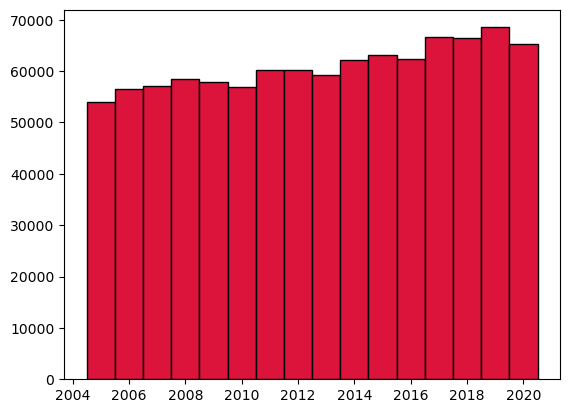

In [31]:
plt.bar(years, deaths_by_year, width=1, color='crimson', ec='black')

# Visualisation des naissances par an

<BarContainer object of 16 artists>

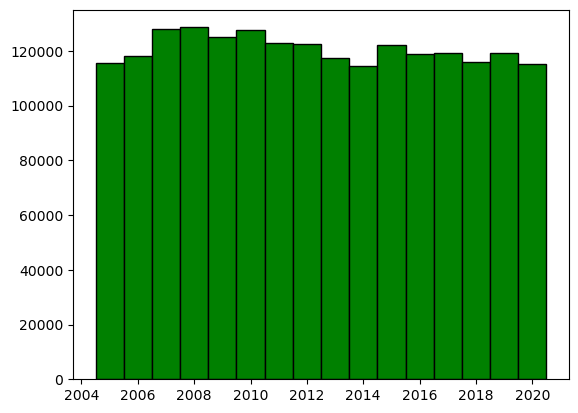

In [32]:
plt.bar(years, births_by_year, width=1, color='green', ec='black')

# Aggregation
Former une nouvelle collection des region et stoquer les décés et naissances de chaqu'une

In [33]:
aggregate = [
    {
        "$lookup": {
            "from": 'deaths',
            "let": {
                "region": '$region',
                "year": '$year',
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                {
                                    "$eq": ['$year', '$year'],
                                },
                                {
                                    "$eq": ['$region', '$$region'],
                                },
                            ],
                        },
                    },
                },
                {
                    "$project": {
                        "_id": 0,
                    },
                },
            ],
            "as": 'deaths',
        },
    },
    {
        "$group": {
            "_id": '$region',
            "births": {
                "$push": {
                    "year": '$year',
                    "region": '$region',
                    "count": '$count',
                },
            },
            "deaths": {"$first": '$deaths'},
        },
    },
    {
        "$project": {
            "region": '$_id',
            "births": '$births',
            "deaths": '$deaths',
        },
    },
    {
        "$project": {"_id": 0},
    },
]

combination_result = db.command('aggregate', 'births', pipeline=aggregate, explain=False)['cursor']['firstBatch']
region.insert_many(combination_result)

# Creation d'un index

In [34]:
region.create_index('{"region":"Northland region"}')

'{"region":"Northland region"}_1'

# affichage d'un index

In [ ]:
for x in region.list_indexes():
    print(x)